# ESTI019 - Codificação de Sinais Multimídia
# Lab6 - Análise LPC da Voz
## Profs. Celso S. Kurashima e Mário Minami

# OBJETIVOS

##1.   Determinação dos parâmetros LPC
##2.   Separação Sonora/Surda
##3.   Espectro,  Envoltória LP e Formantes $f_1$ a $f_4$
##4.   Estimação da $f_0$ e do Pitch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import math

# 1. Separação de uma Estrofe

In [ ]:
audio1 = '/content/drive/MyDrive/CSM/Entre_Leva_Catia_Falada.wav'
print(audio1)
v1 , sr1 = librosa.load(audio1)
print(type(v1), type(sr1))
print(v1.shape, sr1)
# Player será aberto! AGUARDE até abrir!
IPython.display.Audio(data=v1, rate=sr1)

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(15, 5))
librosa.display.waveshow(v1)
plt.title('Voz da Cátia' + audio1)

In [ ]:
fa = sr1
Ts = 0.04
Nj = int(Ts*fa)
Nseg = int(len(v1)/Nj)
Nover = int(Nj*0.5)

In [ ]:
print("Frequencia de amostragem = ",fa, " Hz")

In [ ]:
from scipy import signal
hm = signal.get_window('hamming', Nj)
plt.plot(hm)

In [ ]:
# Só a primeira estrofe
v11 = v1[1:64000]
plt.figure()
fig11, ax11 = plt.subplots(figsize=(15, 3))
librosa.display.waveshow(v11)
plt.title('Voz da Cátia Primeira Estrofe' + audio1)
print(type(v11), type(sr1))
print(v11.shape, sr1)
# Player será aberto! AGUARDE até abrir!
IPython.display.Audio(data=v11, rate=sr1)

# 2. Cálculo dos Parâmetros LPC, separação U/UV e Espectro + Envoltória LPC

In [ ]:
Nover = int(Nj*0.5)
Nseg1 = int(len(v11)/Nj)
p = 10  # ordem da análise LPC
E = []
ind_voz = [0]*Nseg1
t = np.arange(Nj)
for l in range(1, Nseg1-1):
    xjan = v1[(l-1)*Nj+Nover:l*Nj+Nover]*hm
    x2 = list(np.array(xjan**2))
    aux = sum(x2)/Nj
    E.append(aux)
E1 = 10*np.log10(E)
E1min = np.min(E1)
E1 = E1 - E1min   # Coloca o ruído de fundo em 0 dB
E1max = np.max(E1)
# ****************************************************************
# OBSERVAÇÃO:
# ****************************************************************
# ATENÇÃO -> aqui nos arquivos que vocês gravam pode haver diferença
# nos limiares de VAD e U/UV
# É preciso ajustar ambos olhando para os níveis da
# Energia de Tempo Curto E1
# ****************************************************************
# limiar de atividade VAD
E1VAD_lim = E1max - 8
print('Limiar VAD ' + str(E1VAD_lim))
# Limiar U/UV ajustado para 30% do máximo
E1voiced_lim = E1max - 5.3
print('Limiar U/UV ' + str(E1voiced_lim))
# indicador de VAD
ind_voz = np.where(E1 > E1VAD_lim, 1, 0)
ind_voiced = np.where(E1 > E1voiced_lim, 1, 0)
tot_voz = np.sum(ind_voz)
num_voiced = np.sum(ind_voiced)
num_unvoiced = tot_voz - num_voiced
linhas_voiced = math.ceil(num_voiced/4)
linhas_unvoiced = math.ceil(num_unvoiced/4)

print('Sonoros = ' + str(num_voiced) + ' e Surdos = ' + str(num_unvoiced) )
fig1, ax1 = plt.subplots(figsize=(15, 3))
plt.figure(1)
plt.plot(E1)
plt.title('Energia da Voz Primeira Estrofe, ' + audio1)

# partição das figuras voiced
i = 0
fig2, ax2 = plt.subplots(figsize=(20, num_voiced + linhas_voiced))
plt.title('Segmentos Sonoros (Voiced)', color = 'b')

# partição das figuras unvoiced
j = 0
fig3, ax3 = plt.subplots(figsize=(20, num_unvoiced + linhas_unvoiced))
plt.title('Segmentos Surdos (Unvoiced)', color = 'g')

for l in range(1, Nseg1-2):
    # teste de VAD
    if ind_voz[l] == 1:
        xjan = v1[(l-1)*Nj+Nover:l*Nj+Nover]*hm
        a_filter = librosa.lpc(xjan, order=p)
        print("Segmento: ", l, " [ak]: ", a_filter)
        y = signal.lfilter(1, a_filter, xjan)
        e = (xjan - y)/Nj
        # Calcula
        gain_lpc = 10*np.log10(np.sum(e**2))
        w, h = signal.freqz(1,a_filter,worN=int(Nj/2))
        whz = 0.5*fa/np.pi
        LP = 20 * np.log10(abs(h)) + gain_lpc # Imprecisão pelo ganho de lfilter!
        # Teste U/UV

        if E1[l] > E1voiced_lim:

            i += 1
            ax2 = fig2.add_subplot(linhas_voiced,4,i)
            plt.figure(2)
            plt.plot(w, LP, 'b')
            plt.ylabel('Amplitude [dB]', color='b')
            plt.xlabel('Frequency [rad/sample] - Segmento: ' + str(l), color='b')
            sp = np.fft.fft(xjan)
            plt.plot(w, 20*np.log10(abs(sp[0:int(Nj/2)])), 'r')
            plt.minorticks_on()
            plt.grid()
        else:
            j += 1
            ax3 = fig3.add_subplot(linhas_unvoiced,4,j)
            plt.figure(3)
            plt.plot(w, LP, 'g')
            plt.ylabel('Amplitude [dB]', color='b')
            plt.xlabel('Frequency [rad/sample] - Segmento: ' + str(l), color='g')
            sp = np.fft.fft(xjan)
            plt.plot(w, 20*np.log10(abs(sp[0:int(Nj/2)])), 'r')
            plt.minorticks_on()
            plt.grid()
plt.show()





# 2.2 Varie a ordem p entre 8, 12, e 18 e compare a detecção das "formantes" no modelo LPC

# 3. Frequências Formantes
## 3.1 Escolha um valor de p (LPC) e num seguimento encontrar as frequencias normalizadas $f_1$ e $f_2$
## 3.2 Comparar com o triângulo das vogais
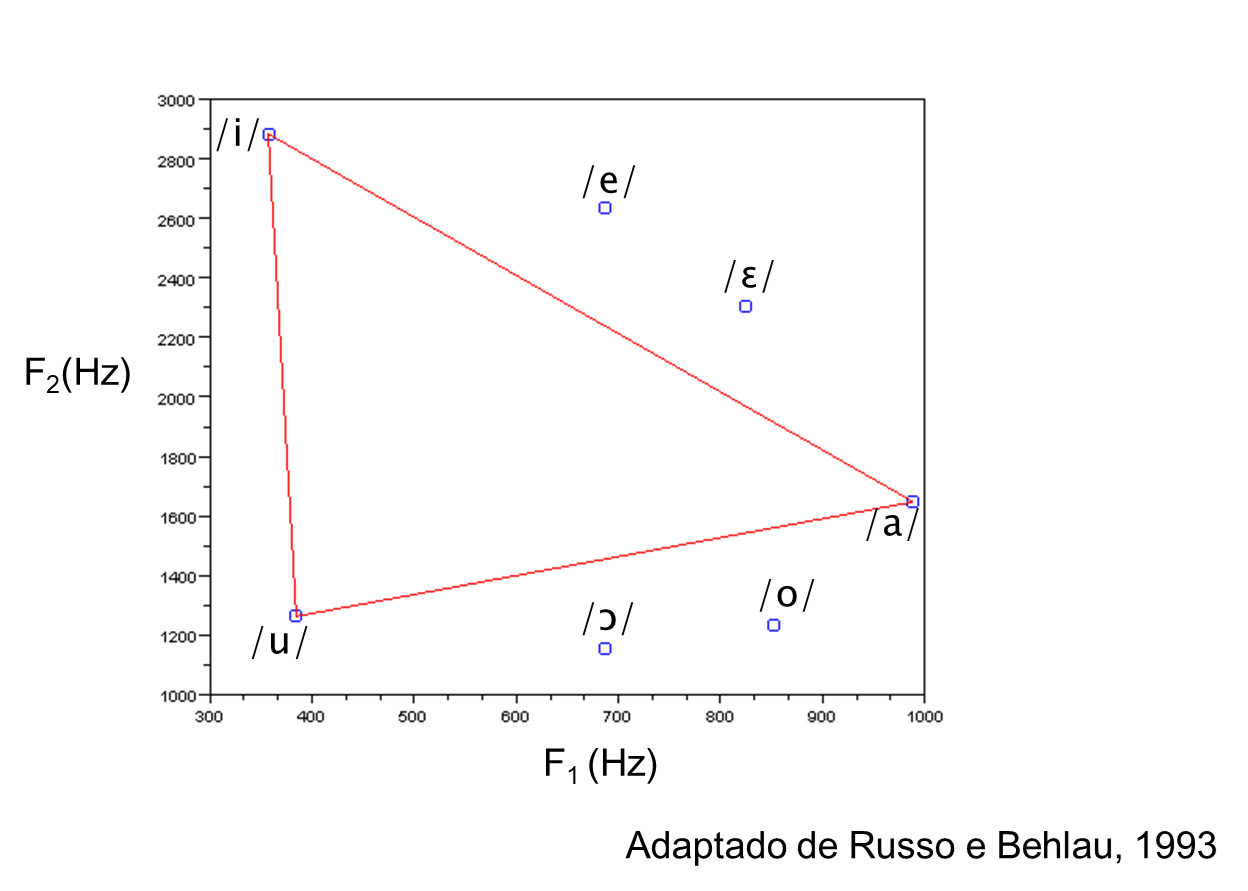


In [ ]:
# P.ex, seguimento 52
f1n = 0.25
f2n = 0.4
f1 = f1n*fa/(2*np.pi)
f2 = f2n*fa/(2*np.pi)
print("F1 = ", f1, "Hz e F2 = ", f2, "Hz")


# 4. Estimação da $f_0$ e do Pitch

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(v1, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C5'))
times = librosa.times_like(f0)
plt.plot(times,f0)
plt.ylabel('[Hz]')
plt.xlabel('tempo [s]')
plt.title('Trajetória da $f_0$ usando algoritmo de pYIN')


In [ ]:
pitch = 1/f0
plt.plot(times,1000*pitch)
plt.ylabel('Pitch [ms]')
plt.xlabel('tempo [s]')
plt.title('Trajetória do Pitch')

Espectrograma enfatizando a $f_0$

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(v1)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Estimação da frequência fundamental por pYIN')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='$f_0$', color='cyan', linewidth=3)
ax.legend(loc='upper right')

# 5. Repita o mesmo procedimento para a sua voz gravada

## 5.1 Refaça para o trecho do poema e para a gravação do seu nome

## 5.2 Encontre três vogais diferentes e suas respectivas formantes

## OBS.: Se houver erro de separação U/UV provavelmente é devido aos níveis de gravação utilizados: ajustar os valores como na OBSERVAÇÃO deste Notebook

# 6. No site (relatório)


##*   Apresente as formas de onda, os espectros sonoros/surdos e os modelados LPC para as GRAVAÇÕES DO GRUPO, analisando os resultados, incluindo todo os áudios utilizados
##*   Apresente também os espectrogramas dos trechos usados nas suas análises e compare com os modelos LPC obtidos



